In [62]:
from qiskit import BasicAer, Aer, IBMQ
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import VQE, ExactEigensolver, NumPyEigensolver
from qiskit.aqua.components.initial_states import Zero
from qiskit.aqua.components.optimizers import ADAM, AQGD, COBYLA, L_BFGS_B, SLSQP
from qiskit.aqua.components.optimizers import SPSA, TNC, POWELL, P_BFGS
from qiskit.aqua.components.optimizers import NFT, NELDER_MEAD, GSLS, CG
from qiskit.aqua.components.variational_forms import RY, RYRZ, SwapRZ
from qiskit.aqua.operators import WeightedPauliOperator, Z2Symmetries
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock

from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import QuantumError, ReadoutError
from qiskit.providers.aer.noise.errors import pauli_error
from qiskit.providers.aer.noise.errors import depolarizing_error
from qiskit.providers.aer.noise.errors import thermal_relaxation_error

from qiskit.providers.aer import noise

from qiskit.tools.monitor import job_monitor

from qiskit.providers.ibmq import least_busy

import warnings

IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
backend = least_busy(provider.backends(simulator=False, operational=True))

import numpy as np
import matplotlib.pyplot as plt
from functools import partial

ibmqfactory.load_account:WARNING:2020-08-07 09:49:49,940: Credentials are already in use. The existing account in the session will be replaced.


In [63]:
distances = []
for inter_dist in range(5, 41):
    inter_dist /= 10.0
    distances.append(inter_dist)
map_type = 'parity'
driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0' + str(inter_dist), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')

In [64]:
# please be aware that the idx here with respective to original idx
freeze_list = [0]
remove_list = [-3, -2] # negative number denotes the reverse order

In [65]:
#Classically solve for the lowest eigenvalue
def exact_solver(qubitOp):
    ee = ExactEigensolver(qubitOp)
    result = ee.run()
    ref = result['energy']
    print('Reference value: {}'.format(ref))
    return ref

In [66]:
backend = BasicAer.get_backend('statevector_simulator')

In [67]:
#Define our noise model based on the ibmq_essex chip
chip_name = 'ibmq_essex'
device = provider.get_backend(chip_name)
coupling_map = device.configuration().coupling_map
noise_model = noise.device.basic_device_noise_model(device.properties())
basis_gates = noise_model.basis_gates

In [ ]:
# Classically solve for the lowest eigenvalue
# This is used just to compare how well you VQE approximation is performing
def exact_solver(qubitOp):
    ee = ExactEigensolver(qubitOp)
    result = ee.run()
    ref = result['energy']
    print('Reference value: {}'.format(ref))
    return ref

def reset_values():
    counts = []
    values = []
    params = []
    deviation = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

# Define your function for computing the qubit operations of LiH
def compute_LiH_qubitOp(map_type, inter_dist, basis='sto3g'):
    
    # Specify details of our molecule
    driver = PySCFDriver(atom='Li 0 0 0; H 0 0 ' + str(inter_dist), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis=basis)

    # Compute relevant 1 and 2 body integrals.
    molecule = driver.run()
    h1 = molecule.one_body_integrals
    h2 = molecule.two_body_integrals
    
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    nuclear_repulsion_energy = molecule.nuclear_repulsion_energy
    
    print("# of electrons: {}".format(num_particles))
    print("# of spin orbitals: {}".format(num_spin_orbitals))

    # Please be aware that the idx here with respective to original idx
    freeze_list = [0,1,6,7]
    remove_list = [0,1,4,5] # negative number denotes the reverse order
    
    # Prepare full idx of freeze_list and remove_list
    # Convert all negative idx to positive
    
    num_spin_orbitals -= len(remove_list)

    # Prepare fermionic hamiltonian with orbital freezing and eliminating, and then map to qubit hamiltonian
    # and if PARITY mapping is selected, reduction qubits
    energy_shift = 0.0
    qubit_reduction = True if map_type == 'parity' else False
    ferOp = FermionicOperator(h1=h1, h2=h2)
    if len(freeze_list) > 0:
        ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
        num_spin_orbitals -= len(freeze_list)
        num_particles -= len(freeze_list)//2
    if len(remove_list) > 0:
        ferOp = ferOp.fermion_mode_elimination(remove_list)
    qubitOp = ferOp.mapping(map_type)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    return qubitOp, num_spin_orbitals, num_particles, qubit_reduction, molecule, energy_shift, nuclear_repulsion_energy

for inter_dist in distances:

    qubitOp, num_spin_orbitals, num_particles, qubit_reduction, molecule, energy_shift, nuclear_repulsion_energy = compute_LiH_qubitOp(map_type, inter_dist)

    # Classically solve for the exact solution and use that as your reference value
    ref = exact_solver(qubitOp)

    # Specify your initial state
    init_state = HartreeFock(num_spin_orbitals, num_particles, qubit_mapping=map_type)

    # Select a state preparation ansatz
    # Equivalently, choose a parameterization for our trial wave function.
    RY_var_form = RY(qubitOp.num_qubits, depth=2)

    # Choose where to run/simulate our circuit
    quantum_instance = backend

    max_eval = 1000

    # Choose the classical optimizer
    POWELL_optimizer = POWELL(max_eval)

    warnings.filterwarnings("ignore")

    COBYLA_vqe = VQE(qubitOp, RY_var_form, SPSA_optimizer, callback=store_intermediate_result)

    COBYLA_vqe_eigenvalue = np.real(COBYLA_vqe.run(backend)['eigenvalue'])

    list_of_values.append(values)
    reset_values()

    COBYLA_vqe_result = np.real(energy_shift + COBYLA_vqe_eigenvalue)
    print("==================================================")
    print('Reference value: {}'.format(ref))
    print("COBYLA VQE value: ", COBYLA_vqe_eigenvalue)
    print("HF energy: {}".format(molecule.hf_energy))
    print("Reference Value Percent Error: " + str(abs((COBYLA_vqe_eigenvalue-ref)/ref)*100) + "%")
    print("Energy Value Percent Error: " + str(np.real(abs((COBYLA_vqe_result-molecule.hf_energy)/molecule.hf_energy))*100) + "%")
    print("==================================================")

    POWELL_vqe = VQE(qubitOp, RY_var_form, POWELL_optimizer)

    POWELL_vqe_eigenvalue = np.real(POWELL_vqe.run(backend)['eigenvalue'])

    list_of_values.append(values)
    reset_values()

    POWELL_vqe_result = np.real(energy_shift + POWELL_vqe_eigenvalue)

    print('Reference value: {}'.format(ref))
    print("POWELL VQE value: ", POWELL_vqe_eigenvalue)
    print("HF energy: {}".format(molecule.hf_energy))
    print("Reference Value Percent Error: " + str(abs((POWELL_vqe_eigenvalue-ref)/ref)*100) + "%")
    print("Energy Value Percent Error: " + str(np.real(abs((POWELL_vqe_result-molecule.hf_energy)/molecule.hf_energy))*100) + "%")
    print("==================================================")

    SPSA_vqe = VQE(qubitOp, RY_var_form, SPSA_optimizer, callback=store_intermediate_result)

    SPSA_vqe_eigenvalue = np.real(SPSA_vqe.run(backend)['eigenvalue'])

    list_of_values.append(values)
    reset_values()

    # Now compare the results of different compositions of your VQE algorithm!
    SPSA_vqe_result = np.real(energy_shift + SPSA_vqe_eigenvalue)

    print('Reference value: {}'.format(ref))
    print("SPSA VQE energy: ", SPSA_vqe_eigenvalue)
    print("HF energy: {}".format(molecule.hf_energy))
    print("SPSA Reference Value Percent Error: " + str(abs((SPSA_vqe_eigenvalue-ref)/ref)*100) + "%")
    print("SPSA Energy Value Percent Error: " + str(np.real(abs((SPSA_vqe_result-molecule.hf_energy)/molecule.hf_energy))*100) + "%")
    print("==================================================")


    TNC_vqe = VQE(qubitOp, RY_var_form, TNC_optimizer)

    TNC_vqe_eigenvalue = np.real(TNC_vqe.run(backend)['eigenvalue'])

    list_of_values.append(values)
    reset_values()

    TNC_vqe_result = np.real(energy_shift + TNC_vqe_eigenvalue)

    print('Reference value: {}'.format(ref))
    print("TNC VQE energy: ", TNC_vqe_eigenvalue)
    print("HF energy: {}".format(molecule.hf_energy))
    print("TNC Reference Value Percent Error: " + str(abs((TNC_vqe_eigenvalue-ref)/ref)*100) + "%")
    print("TNC Energy Value Percent Error: " + str(np.real(abs((TNC_vqe_result-molecule.hf_energy)/molecule.hf_energy))*100) + "%")
    print("==================================================")


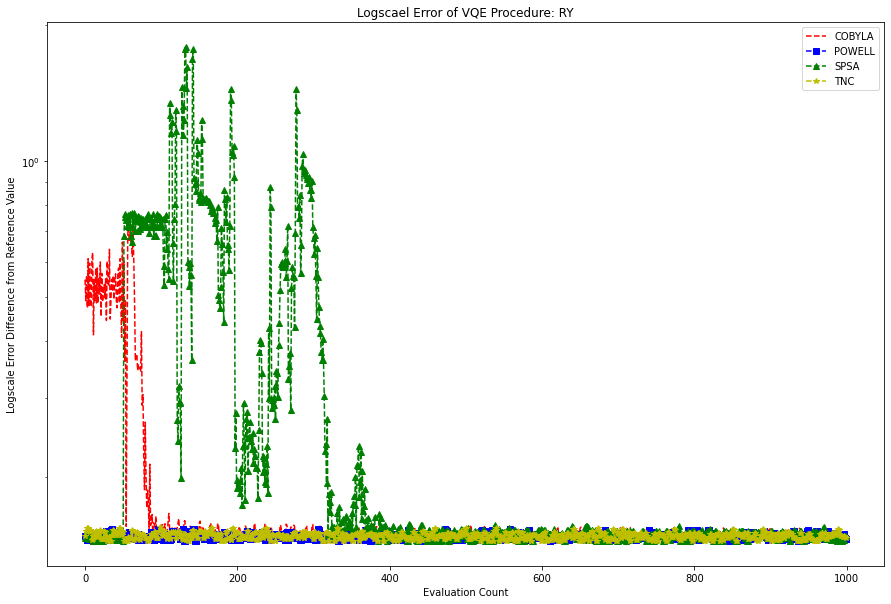

In [69]:
graph1 = plt.figure(figsize=(15,10))
names = ['COBYLA', 'POWELL', 'SPSA', 'TNC']
colors = ['r','g','b','y']
plt.xlabel('Evaluation Count')
plt.ylabel('Logscale Error Difference from Reference Value')
plt.title('Logscael Error of VQE Procedure: RY')
plt.yscale('log')
iterations = []
count = 0
for i in range(1000):
    iterations.append(i)
COBYLA = []
SLSQP = []
SPSA = []
TNC = []
for i in iterations:
    COBYLA.append(((list_of_values[0][count] - ref)/ref))
    count += 1
for i in iterations:
    SLSQP.append(((list_of_values[1][count]-ref)/ref))
    count += 1
for i in iterations:
    SPSA.append(((list_of_values[2][count]-ref)/ref))
    count += 1
for i in iterations:
    TNC.append(((list_of_values[3][count]-ref)/ref))
    count += 1
plt.plot(iterations, COBYLA, 'r--', iterations, SLSQP, 'bs--', iterations, SPSA, 'g^--', iterations, TNC, 'y*--')
plt.legend(names)

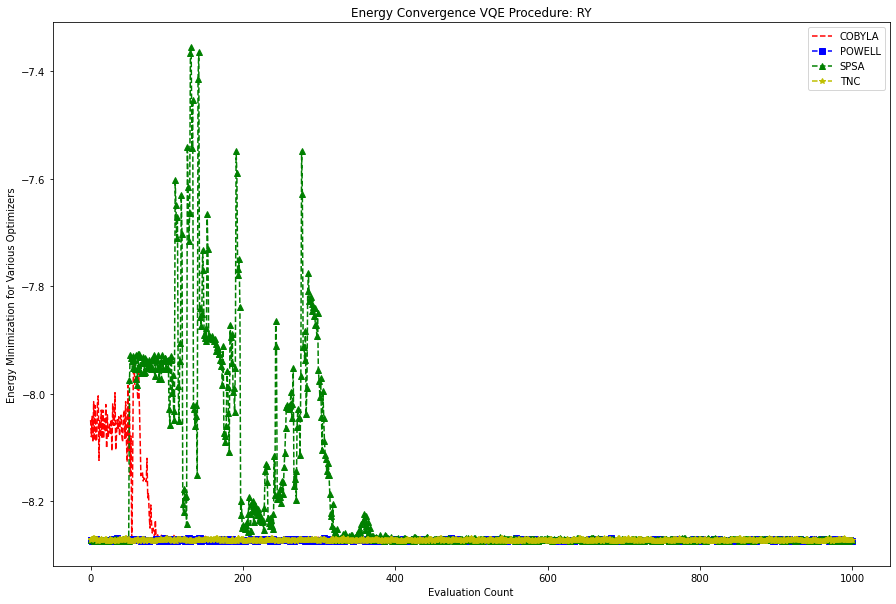

In [56]:
graph2 = plt.figure(figsize=(15,10))
names = ['COBYLA', 'POWELL', 'SPSA', 'TNC']
colors = ['r','g','b','y']
plt.xlabel('Evaluation Count')
plt.ylabel('Energy Minimization for Various Optimizers')
plt.title('Energy Convergence VQE Procedure: RY')
iterations = []
count = 0
for i in range(1000):
    iterations.append(i)
COBYLA = []
SLSQP = []
SPSA = []
TNC = []
for i in iterations:
    COBYLA.append(energy_shift + list_of_values[0][count])
    count += 1
for i in iterations:
    SLSQP.append(energy_shift + list_of_values[1][count])
    count += 1
for i in iterations:
    SPSA.append(energy_shift + list_of_values[2][count])
    count += 1
for i in iterations:
    TNC.append(energy_shift + list_of_values[3][count])
    count += 1
plt.plot(iterations, COBYLA, 'r--', iterations, SLSQP, 'bs--', iterations, SPSA, 'g^--', iterations, TNC, 'y*--')
plt.legend(names)